## Binary Classification with a Bank Churn Dataset
Objective of this model is to predict whether a customer continues with their account or closes it (e.g., churns).

In [ ]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Install dataset from Kaggle

In [ ]:
# download contest data
! kaggle competitions download -c playground-series-s4e1
! unzip playground-series-s4e1.zip

  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 107MB/s]
Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


First, let's import training data. Before we continue, we perform some data pre-processing. In our data, we have columns of non-numerical data. We drop irrelevant ones and one-hot encode ones that do. Then, we scale numerical features as they originally consist of different ranges. We then finally allocate 20% of training data for validation testing.

In [5]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

data_path = './train.csv'
loaded_data = pd.read_csv(data_path)

# Drop irrelevant columns (id, CustomerId, Surname)
loaded_data = loaded_data.drop(columns=["id", "CustomerId", "Surname"])

# one-hot encode categorical variables
loaded_data = pd.get_dummies(loaded_data, columns=["Geography", "Gender"])

# Seperate features and labels
loaded_labels = loaded_data["Exited"]
loaded_data = loaded_data.drop(columns=["Exited"])

loaded_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1,0,1


Now, define model. We first make an attempt with a seque

Model: "Bank_Churn_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 13)]              0         
                                                                 
 dense_79 (Dense)            (None, 32)                448       
                                                                 
 dropout_52 (Dropout)        (None, 32)                0         
                                                                 
 dense_80 (Dense)            (None, 16)                528       
                                                                 
 dropout_53 (Dropout)        (None, 16)                0         
                                                                 
 dense_81 (Dense)            (None, 1)                 17        
                                                                 
Total params: 993 (3.88 KB)
Trainable params: 993 

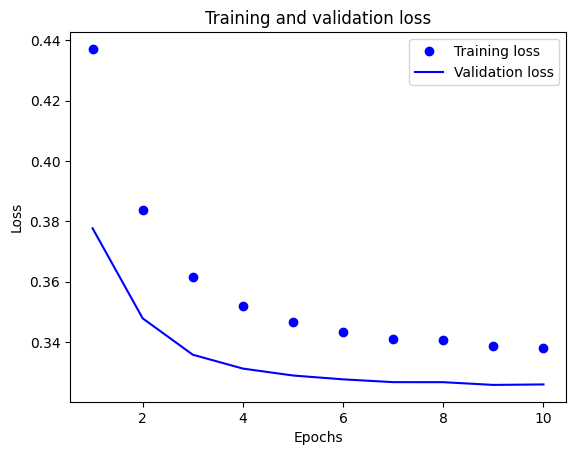

In [32]:
# Split the data into training+validation and test sets
temp_data, test_data, temp_labels, test_labels = train_test_split(
    loaded_data, loaded_labels, test_size=0.2, random_state=42
)

# Further split the temporary data into training (80%) and validation (20%)
train_data, validation_data, train_labels, validation_labels = train_test_split(
    temp_data, temp_labels, test_size=0.2, random_state=42
)

# Normalize/Standardize numerical features
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
validation_data = scaler.fit_transform(validation_data)

input_shape = loaded_data.shape[1:]
input_shape

def build_model():
  inputs = layers.Input(shape=input_shape)
  hidden = layers.Dense(32, activation='relu')(inputs)
  hidden = layers.Dropout(0.2)(hidden)
  hidden = layers.Dense(16, activation='relu')(hidden)
  hidden = layers.Dropout(0.2)(hidden)
  outputs = layers.Dense(1, activation='sigmoid')(hidden)

  model = keras.models.Model(inputs=inputs, outputs=outputs, name="Bank_Churn_Model")

  model.compile(optimizer=RMSprop(),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

model = build_model()
model.summary()
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(validation_data, validation_labels))

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()




Training further results in validation loss and training loss plateuing, stop training at 20 epochs. Next, we evaluate model performance on test-data set.

In [34]:
test_data = scaler.fit_transform(test_data)

loss_of_model, accuracy_of_model = model.evaluate(test_data, test_labels)
print(loss_of_model)
print(accuracy_of_model)

1032/1032 [==============================] - 1s 1ms/step - loss: 0.3234 - accuracy: 0.8644
0.32343974709510803
0.8643923997879028
